In [21]:
%matplotlib inline
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean



14
11
[array([[0.5, 0.5, 0.5],
       [0.5, 0. , 0.5],
       [1. , 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5]]), array([[1. , 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5]])]
[[0 1 1]
 [0 0 0]]


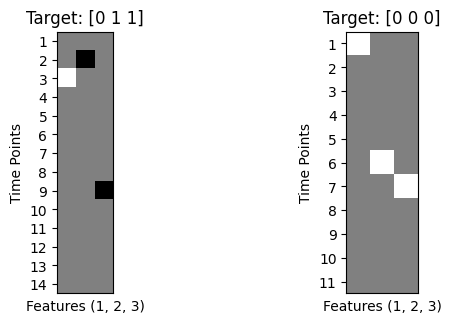

In [142]:
def generateTrainData(
    samples, noise, delayRange, baseTPS=[0, 1, 2, 3, 4], conceptNoise=[0.0, 0.0, 0.0]
):
    # Initialize lists to store the sequences and their corresponding targets.
    sequences = []
    targets = []

    # Loop to generate the specified number of samples.
    for _ in range(samples):
        # Randomly select three unique time points from baseTPS for concept encoding.
        tps = numpy.random.choice(baseTPS, 3, replace=False)
        # Randomly choose a binary concept for each of the three features.
        concept = numpy.random.choice([0, 1], 3)
        # Initialize the sequence with a baseline value and add a random delay.
        seq = numpy.zeros((len(baseTPS) + numpy.random.choice(delayRange), 3)) + 0.5

        # Loop through each selected time point and encode the concept.
        for i, tp in enumerate(tps):
            # Check if concept noise should be applied.
            if numpy.random.random() < conceptNoise[i]:
                # Retain the baseline value if concept noise is applied.
                V = seq[tp]
            else:
                # Set the concept at the time point: 1.0 or 0.0 adjusted by 0.5.
                V = numpy.array([0.5, 0.5, 0.5])
                V[i] = 1.0 if concept[i] == 0 else 0.0
            # Assign the concept values to the sequence at the chosen time point.
            seq[tp] = V

        # Add Gaussian noise to the entire sequence.
        seq += numpy.random.normal(0.0, noise, seq.shape)
        # Ensure the sequence values are within the range [0.0, 1.0].
        seq = numpy.clip(seq, 0.0, 1.0)
        # Append the generated sequence and its target concept to the lists.
        sequences.append(seq)
        targets.append(concept)

    # Return the list of sequences and the numpy array of targets.
    return sequences, numpy.array(targets)


# Example usage of the function:
# Generate 10 sequences with a specific noise level and delay range.
s, t = generateTrainData(
    2, 0.0, [1, 2, 3, 4, 5], baseTPS=[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
)
print(len(s[0]))
print(len(s[1]))
#print(len(s[2]))
print(s)

print(t)

# Plotting the sequences with detailed time points on the Y-axis
plt.figure(figsize=(15, 15))  # Increased figure size for better visibility

for i in range(len(s)):
    ax = plt.subplot(5, 5, i + 1)
    im = ax.imshow(s[i], cmap="gray", vmin=0.0, vmax=1.0)
    plt.title(f"Target: {t[i]}")

    # Setting labels for features (X-axis) and detailed time points (Y-axis)
    plt.xlabel("Features (1, 2, 3)")
    plt.ylabel("Time Points")

    # Setting tick marks for each time point on the Y-axis
    ax.set_yticks(range(s[i].shape[0]))
    ax.set_yticklabels([f"{j+1}" for j in range(s[i].shape[0])])

    # Removing X-axis tick marks
    plt.xticks([])

plt.tight_layout()
plt.show()

In [35]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.attention = Attention(hidden_dim)
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 3)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim)
        rnn_out, _ = self.rnnLayer(x, h0)
        rnn_out = torch.tanh(rnn_out)
        attn_out = self.attention(rnn_out)
        out = torch.sigmoid(self.outputLayer(attn_out))
        return out

    def resetHidden(self):
        self.hidden = list()

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                out, h0 = self.rnnLayer(x[l][i].reshape((1, 1, self.inp)), h0)
                H.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
            out = torch.tanh(out)
            out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
                # print(out.detach().numpy().flatten().shape)
        return numpy.array(O), numpy.array(H)

In [41]:
model = NetRNNWithAttention(hidden_dim=12, inp=3)
s, t = generateTrainData(100, 0.1, [5])
output = model(torch.Tensor(s))
print(output.shape)
print(model)

torch.Size([100, 3])
NetRNNWithAttention(
  (rnnLayer): RNN(3, 12, batch_first=True)
  (attention): Attention(
    (attention): Linear(in_features=12, out_features=12, bias=True)
  )
  (outputLayer): Linear(in_features=12, out_features=3, bias=True)
)


In [42]:
numpy.round([0, 0.5, 1.0], 1)

array([0. , 0.5, 1. ])

In [43]:
error = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
collectorA = dict()
for cond, td in enumerate([[1, 2, 3, 4, 5], [1], [2], [3], [4], [5]]):
    # if cond>3:
    if True:
        for rep in range(20):
            for kind in ["RNN"]:
                if kind == "RNN":
                    model = NetRNNWithAttention(hidden_dim=12)
                optimizer = optim.Adam(model.parameters())
                error = nn.MSELoss()
                acc = 0.0
                W = []
                A = []
                while acc < 0.97:
                    model.resetHidden()
                    s, t = generateTrainData(
                        100, 0.05, td, baseTPS=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                    )
                    s = numpy.array(s)  # Convert to numpy array
                    divs = []
                    for i in range(
                        s.shape[0]
                    ):  # use 64 when training for single delayRange
                        optimizer.zero_grad()
                        output = model(
                            torch.Tensor(s[i].reshape(1, s[i].shape[0], 3))
                        )  # shape greater than 8
                        loss = error(output, torch.Tensor(t[i]))
                        loss.backward()
                        optimizer.step()
                        div = output.detach().numpy().reshape(t[i].shape) - t[i]
                        divs.append(1.0 - abs(div).mean())
                    W.append(loss.item())
                    acc = mean(divs)
                    A.append(acc)
                    # print(len(W),acc)
                    if acc < 0.97 and len(A) > 2000:
                        if kind == "RNN":
                            model = NetRNNWithAttention(hidden_dim=12)
                        optimizer = optim.Adam(model.parameters())
                        error = nn.MSELoss()
                        acc = 0.0
                        W = []
                        A = []
                        print("repeat")
                # collectorA["{0} {1} {2}".format(kind,cond,rep)]=A
                # torch.save(model,"modelsLongDelay/model_{0}_{1}_{2}.model".format(kind,cond,rep))
                print("{0} {1} {2}".format(kind, cond, rep), len(A))

In [50]:
# Given arrays
array_A = np.full(common_length, 0.5)
array_B = np.full(common_length, 0.5)
array_C = np.full(common_length, 0.5)

# Random index for array A
index_A = np.random.randint(common_length)
value_A = np.random.choice([0, 1])
array_A[index_A] = value_A

# Different random index for array B
indices_B = np.delete(np.arange(common_length), index_A)  # Removing the index used in Array A
index_B = np.random.choice(indices_B)
value_B =  np.random.choice([0, 1])
array_B[index_B] = value_B

# Setting the last index of array C to either 0 or 1
value_C = np.random.choice([0, 1])
array_C[-1] = value_C

# Generating label based on value_C
# Perform XOR if C is 0, perform XNOR if C is 1
label = int((value_A != value_B) if value_C == 0 else (value_A == value_B))

# Outputting the arrays and the label
array_A, array_B, array_C, label



(array([0.5, 0.5, 0.5, 0.5, 1. , 0.5]),
 array([1. , 0.5, 0.5, 0.5, 0.5, 0.5]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0. ]),
 0)

In [51]:
# Creating a DataFrame with the arrays
df = pd.DataFrame({'Array A': array_A, 'Array B': array_B, 'Array C': array_C})
df


,Array A,Array B,Array C
0,0.5,1.0,0.5
1,0.5,0.5,0.5
2,0.5,0.5,0.5
3,0.5,0.5,0.5
4,1.0,0.5,0.5
5,0.5,0.5,0.0


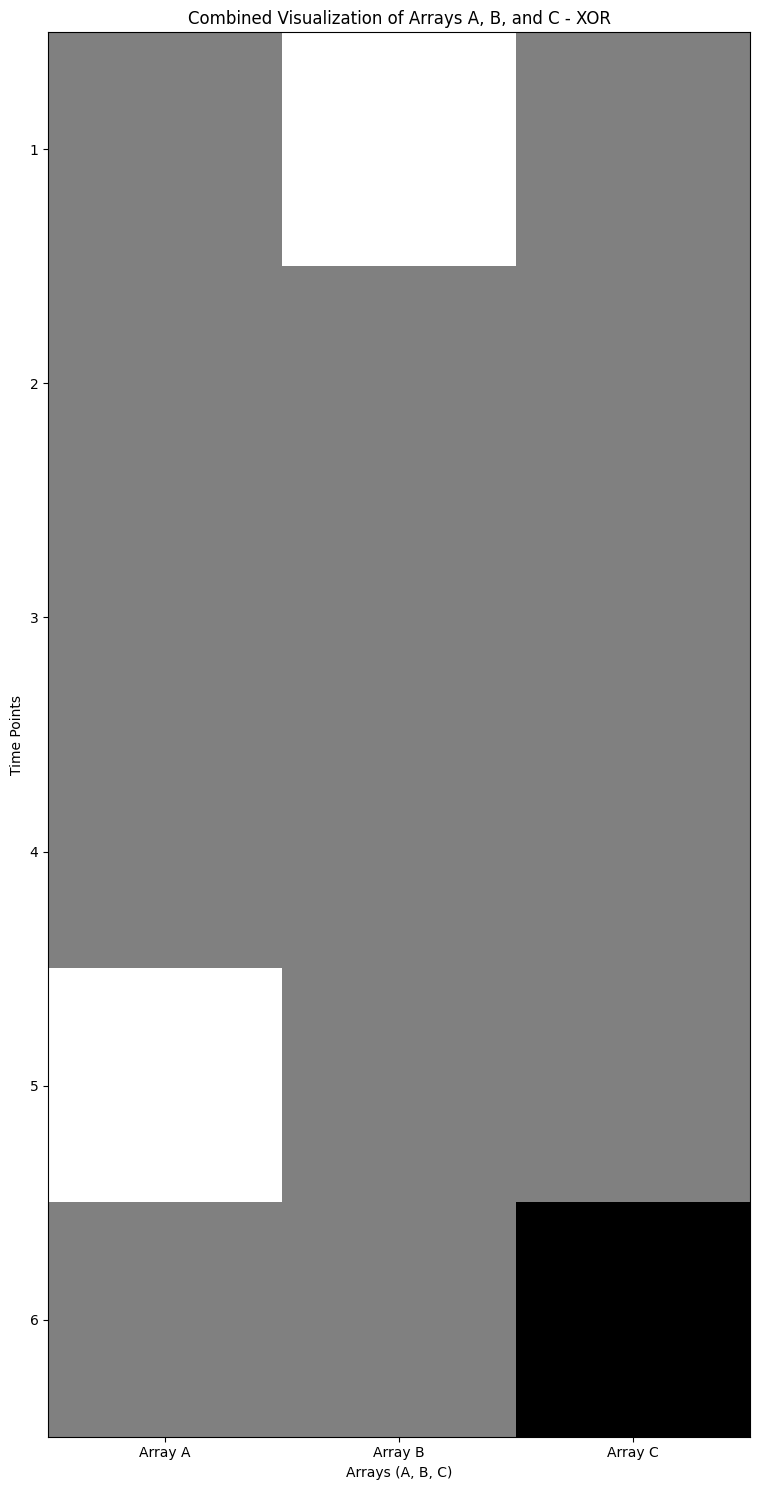

In [59]:
import matplotlib.pyplot as plt

# Assuming array_A, array_B, array_C are defined as in your previous code
reshaped_A = array_A.reshape(-1, 1)
reshaped_B = array_B.reshape(-1, 1)
reshaped_C = array_C.reshape(-1, 1)

# Combining the reshaped arrays into a single array for visualization
combined_array = np.hstack([reshaped_A, reshaped_B, reshaped_C])

# Determining the label for the title
label = array_C[-1]  # Last element of Array C
operation_title = "XOR" if label == 0 else "AND"

# Plotting
plt.figure(figsize=(15, 15))

# Displaying the combined array
ax = plt.imshow(combined_array, cmap='gray', vmin=0.0, vmax=1.0)

# Setting the title with the operation label
plt.title(f"Combined Visualization of Arrays A, B, and C - {operation_title}")

# Setting labels for features (X-axis) and detailed time points (Y-axis)
plt.xlabel("Arrays (A, B, C)")
plt.ylabel("Time Points")

# Setting tick marks for each time point on the Y-axis
plt.yticks(range(combined_array.shape[0]), [f"{j+1}" for j in range(combined_array.shape[0])])

# Setting tick marks for each array on the X-axis
plt.xticks(range(3), ['Array A', 'Array B', 'Array C'])

plt.tight_layout()
plt.show()


In [58]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.attention = SelfAttention(inp)  # Attention layer with input dimension
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.inp = inp
        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Applying attention first
        attn_out = self.attention(x)

        # Feeding the output of the attention layer into the RNN
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Applying the final output layer
        out = torch.sigmoid(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out
    
    
    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Feeding the output of the attention layer into the RNN
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())
                
        return np.array(O), np.array(H)
    
    
model = NetRNNWithAttention()

In [145]:
def generateTrainData(num_samples, min_length, max_length):
    s = []  # Sequences (list of arrays)
    t = []  # Targets (list of labels)

    for _ in range(num_samples):
        # Randomized common length between min_length and max_length
        common_length = np.random.randint(min_length, max_length + 1)

        # Given arrays
        array_A = np.full(common_length, 0.5)
        array_B = np.full(common_length, 0.5)
        array_C = np.full(common_length, 0.5)

        # Random index for array A
        index_A = np.random.randint(common_length)
        value_A = np.random.choice([0, 1])
        array_A[index_A] = value_A

        # Different random index for array B
        indices_B = np.delete(np.arange(common_length), index_A)  # Removing the index used in Array A
        index_B = np.random.choice(indices_B)
        value_B = np.random.choice([0, 1])
        array_B[index_B] = value_B

        # Setting the last index of array C to either 0 or 1
        value_C = np.random.choice([0, 1])
        array_C[-1] = value_C

        # Generating label based on value_C
        label = int((value_A != value_B) if value_C == 0 else (value_A == value_B))
        label_arr = [label]
        # Combine arrays
        combined_array = np.vstack([array_A, array_B, array_C]).T

        s.append(combined_array)
        t.append(label_arr)

    return s, numpy.array(t)  # Returning as lists


In [147]:
num_seq= 2
array_min_length = 5
array_max_length = 10
sequences, labels  = generateTrainData(num_seq, array_min_length,array_max_length)
sequences, labels


([array([[0. , 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 1. , 0.5],
         [0.5, 0.5, 1. ]]),
  array([[0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0. , 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 1. , 0.5],
         [0.5, 0.5, 0. ]])],
 array([[0],
        [1]]))

In [148]:
print(len(sequences[0]))
print(len(sequences[1]))

6
9


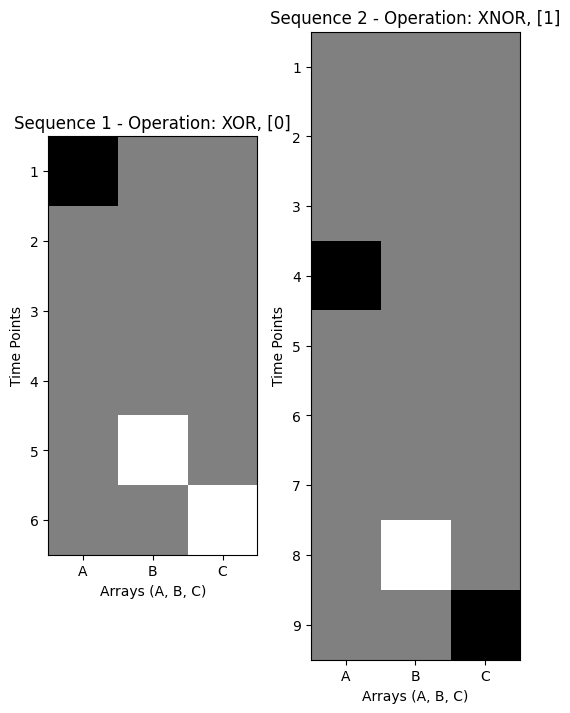

In [150]:
# Assuming sequences and labels are already generated using generateTrainData
num_samples = len(sequences)  # Number of samples to display

# Plotting
# Adjust the figure size to accommodate horizontal layout
plt.figure(figsize=(3 * num_samples, 15))

for i, (seq, label) in enumerate(zip(sequences, labels)):
    # Reshape each sequence for visualization
    reshaped_sequence = seq  # Use the sequence as it is

    # Add a subplot for each sequence in a horizontal layout
    ax = plt.subplot(1, num_samples, i + 1)
    img = ax.imshow(reshaped_sequence, cmap='gray', vmin=0.0, vmax=1.0)

    # Determine the operation title based on the label
    operation_title = "XOR" if label == 0 else "XNOR"

    # Setting the title with the operation label
    ax.set_title(f"Sequence {i+1} - Operation: {operation_title}, {label}")

    # Setting labels for features (X-axis) and detailed time points (Y-axis)
    ax.set_xlabel("Arrays (A, B, C)")
    ax.set_ylabel("Time Points")

    # Setting tick marks for each array on the X-axis
    ax.set_xticks(range(3))
    ax.set_xticklabels(['A', 'B', 'C'])

    # Setting tick marks for each time point on the Y-axis
    # Here, the number of ticks should be equal to the length of the sequence (number of rows)
    ax.set_yticks(range(reshaped_sequence.shape[0]))
    ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

# Adding a colorbar as the key, placed at the side
# cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust these values as needed for positioning
# cbar = plt.colorbar(img, cax=cbar_ax)
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['0 (Black)', '1 (White)'])

# Adjust the main figure to make room for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [152]:
import torch
import torch.optim as optim
import torch.nn as nn
from statistics import mean

collectorA = dict()
array_min_length = 5  # Define the min length of Arrays A, B, C
array_max_length = 10  # Define the max length of Arrays A, B, C

for rep in range(1):
    model = NetRNNWithAttention(hidden_dim=12)
    optimizer = optim.Adam(model.parameters())
    error = nn.MSELoss()
    acc = 0.0
    W = []
    A = []

    while acc < 0.97:
        model.resetHidden()
        sequences, targets = generateTrainData(2, array_min_length, array_max_length)

        divs = []
        for seq, target in zip(sequences, targets):
            optimizer.zero_grad()
            # Process each sequence individually
            print(seq)
            print(target)
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
            target_tensor = torch.tensor([target], dtype=torch.float32)  # Add batch dimension

            output = model(seq_tensor)
            loss = error(output, target_tensor)
            loss.backward()
            optimizer.step()

            div = output.detach().numpy() - target_tensor.numpy()
            divs.append(1.0 - abs(div).mean())

        W.append(loss.item())
        acc = mean(divs)
        A.append(acc)

        # Restart training if not converging
        if acc < 0.97 and len(A) > 2000:
            model = NetRNNWithAttention(hidden_dim=12)
            optimizer = optim.Adam(model.parameters())
            acc = 0.0
            W = []
            A = []
            print("repeat")

    print(f"RNN {rep}", len(A))


[[0.5 0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.  0.5 0.5]
 [0.5 0.5 1. ]]
[1]
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 1.  0.5]
 [1.  0.5 0. ]]
[0]
[[0.5 0.5 0.5]
 [0.5 1.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [1.  0.5 1. ]]
[1]
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.  0.5]
 [0.  0.5 0.5]
 [0.5 0.5 0. ]]
[0]
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.  0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 1. ]]
[1]
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 1.  0.5]
 [0.5 0.5 0.5]
 [1.  0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0. ]]
[0]
[[0.5 0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.  0.5 1. ]]
[1]
[[0.5 0.5 0.5]
 [0.5 0.  0.5]
 [1.  0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 1. ]]
[0]
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0.5]


c:\Users\ahmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 1.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [1.  0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 1. ]]
[1]
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.  0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0. ]]
[0]
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [1.  0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 1.  0. ]]
[0]
[[0.  0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 1. ]]
[1]
[[0.5 1.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.  0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 1. ]]
[0]
[[0.5 0.5 0.5]
 [0.  0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0. ]]
[0]
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [1.  0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0. ]]
[1]
[[0.5 0.5 0.5]
 [0.5 1.  0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5

KeyboardInterrupt: 